In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

In [2]:
# specify OS - used for making directory paths
os = 'linux'
#os = 'windows'

# Download data

In [3]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml

data_set = 'mnist'

if data_set == 'mnist':
    raw_data = fetch_openml('mnist_784')
else:
    assert False

In [4]:
raw_data_x = np.array((raw_data['data']+0.5)/256.0)
raw_data_y = np.array(raw_data['target'].astype('int8'))

# separate classes 0,1,2 into a new dataset
# accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)| (raw_data_y == 2)
accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)

raw_data_x = raw_data_x[accptbl_cats]
raw_data_y = raw_data_y[accptbl_cats]
num_classes = 2
img_sz = (28,28)

data_dim = raw_data_x.shape[1]

## Split data into training and validation

In [5]:
def display_image(x,lbl=None):
    if len(x.shape) == 3:
        plt.imshow(x)
    elif len(x.shape) == 1:
        plt.imshow(x.reshape(img_sz))
    plt.xticks([])
    plt.yticks([])
    if lbl is not None:
        plt.title(lbl)

def split_data(x,y,fracs=[0.8,0.2],seed=0):
    """
    Randomly splits data into two sets.

    Inputs: x, y, fracs=[0.8, 0.2], seed=0
    x - NxD matrix of x data (e.g. images)
    y - Nx1 vector of y data (e.g. labels)
    fracs - split fractions determining sizes of set one and set two.
    seed - random seed. 'None' disables the use of a new seed.

    Outputs: x1, y1, x2, y2
    x1 - (fracs[0]*N)xD matrix of x data of set 1
    y1 - (fracs[0]*N)x1 vector of y data of set 1
    x2 - (fracs[1]*N)xD matrix of x data of set 2
    y2 - (fracs[1]*N)x1 vector of y data of set 2
    """
    if seed is not None:
        np.random.seed(seed)
    N = x.shape[0]
    rp = np.random.permutation(N)

    N1 = int(fracs[0]*N)
    N2 = min(N-N1,int(fracs[1]*N))

    # Split the data into two parts
    x1 = x[rp[:N1]]
    y1 = y[rp[:N1]]
    x2 = x[rp[N1:(N1+N2)]]
    y2 = y[rp[N1:(N1+N2)]]

    return x1,y1,x2,y2

In [6]:
train_x,train_y,test_x,test_y = split_data(raw_data_x,raw_data_y,fracs=[0.01,0.01])
train_x,train_y,  val_x,val_y = split_data(train_x,train_y,fracs=[0.6,0.4])

In [7]:
print('num_train = ' + str(train_x.shape[0]))
print('num_val = ' + str(val_x.shape[0]))
print('num_test = ' + str(test_x.shape[0]))
print('num_classes = '+str(num_classes))

num_train = 88
num_val = 58
num_test = 147
num_classes = 2


# Explore the data

48.86% of the training data is class 0, corresponding to 43 data points
51.14% of the training data is class 1, corresponding to 45 data points


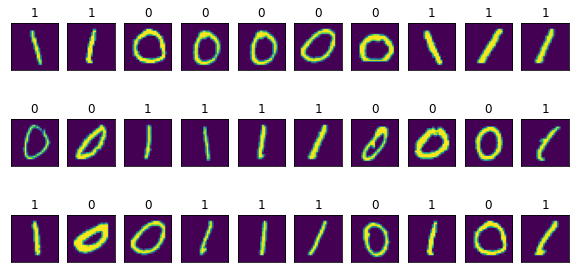

In [8]:
# Print statistics
num_train = len(train_y)
num_val = len(val_y)
for i in range(num_classes):
    num_class_i = np.sum(train_y == i)
    print('{:.2f}% of the training data is class {}, corresponding to {} data points'.format(100*num_class_i/num_train,
                                                                                       i, num_class_i))

# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,train_x.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    display_image(train_x[ind,:],
                train_y[ind])



# Extract SIFT keypoints and descriptors

## Prepare data

In [9]:
# convert train and validation images to 2D with 3 channels of [0,255] pixel values
train_x_sift = ((train_x.reshape((train_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
train_x_sift = np.broadcast_to(train_x_sift, (train_x.shape[0], img_sz[0], img_sz[1], 3))

val_x_sift = ((val_x.reshape((val_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
val_x_sift = np.broadcast_to(val_x_sift, (val_x.shape[0], img_sz[0], img_sz[1], 3))

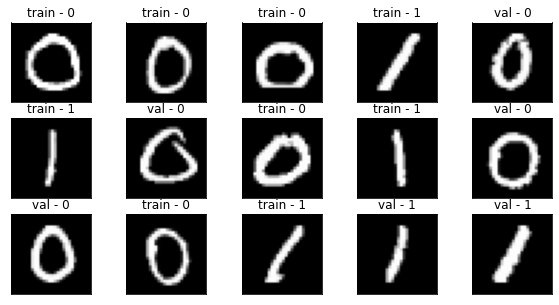

In [10]:
# Visualize a few images
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    plt.subplot(num_rows,num_digits,i+1)
    if np.random.random() > 0.5:
        ind = np.random.randint(0,train_x_sift.shape[0])
        display_image(train_x_sift[ind], 'train - '+str(train_y[ind]))
    else:
        ind = np.random.randint(0,val_x_sift.shape[0])
        display_image(val_x_sift[ind], 'val - '+str(val_y[ind]))

## Extract SIFT keypoints and descriptors

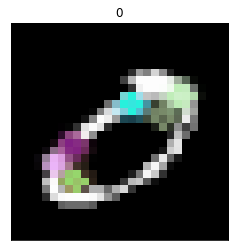

In [11]:
# extract SIFT descriptors for one image
gray= cv.cvtColor(train_x_sift[0],cv.COLOR_BGR2GRAY)

# SIFT default parameter values
nfeatures = 0
nOctaveLayers = 3
contrastThreshold = 0.04
edgeThreshold = 10
sigma = 1.6

# SIFT custom parameter values
# nfeatures = 0
# nOctaveLayers = 20
# contrastThreshold = 0.04
# edgeThreshold = 5
# sigma = 1.6

sift = cv.SIFT_create(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma)

kp, des = sift.detectAndCompute(gray,None)
img=cv.drawKeypoints(gray,kp,0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display_image(img, train_y[0])

In [12]:
# extract SIFT descriptors for all training and validation images
gray = np.array([cv.cvtColor(train_x_sift[0],cv.COLOR_BGR2GRAY)])
for i in range(1, train_x_sift.shape[0]):
    gray = np.append(gray, [cv.cvtColor(train_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
for i in range(val_x_sift.shape[0]):
    gray = np.append(gray, [cv.cvtColor(val_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
kp = []
des = []
for i in range(gray.shape[0]):
    _kp, _des = sift.detectAndCompute(gray[i],None)
    kp.append(_kp)
    des.append(_des)

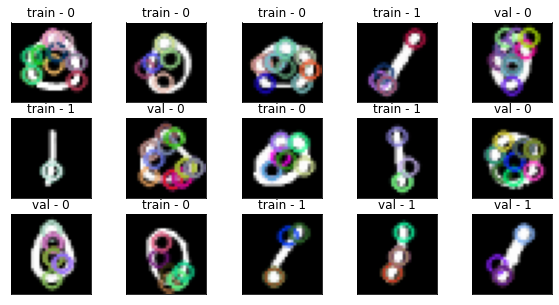

In [13]:
# visualize a few keypoints
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    
    if np.random.random() > 0.5:
        ind = np.random.randint(0,num_train)
        title = 'train - '+str(train_y[ind])
    else:
        ind = np.random.randint(num_train,num_train+num_val)
        title = 'val - '+str(val_y[ind-num_train])
        
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray[ind],kp[ind],0)
    #img=cv.drawKeypoints(gray[ind],kp[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_image(img, title)

In [14]:
# show statistics of the number of keypoints found in each training or validation image
num_keypoints = [len(kp[i]) for i in range(len(kp))]
print('# of train & val images: {} ({} train & {} val)'.format(num_train+num_val, num_train, num_val))
print('min # of keypoints: ' + str(min(num_keypoints)))
print('max # of keypoints: ' + str(max(num_keypoints)))
for i in range(2):
    temp = np.sum(np.array(num_keypoints) == i)/len(num_keypoints)*100
    print('{:.1f}% of images have {} keypoints'.format(temp, i))

# of train & val images: 146 (88 train & 58 val)
min # of keypoints: 0
max # of keypoints: 21
6.2% of images have 0 keypoints
1.4% of images have 1 keypoints


## Select only two keypoints for each image

1. Discard all images with less than two keypoints.
2. Select keypoints closest to the top and bottom borders. This method will hopefully retain keypoints at corners of a 1 digit.
3. Concatenate two descriptors (of size 128) to form one feature vector (of size 256) for each image

In [15]:
# discard all images that have less than 2 keypoints
to_discard_ind = [i for i in range(len(num_keypoints)) if (num_keypoints[i]==0 or num_keypoints[i]==1)]
x_sift_mod = np.delete(np.append(train_x_sift, val_x_sift, axis=0), to_discard_ind, axis=0)
y_mod = np.delete(np.append(train_y, val_y, axis=0), to_discard_ind, axis=0)
gray_mod = np.delete(gray, to_discard_ind, axis=0)
kp_mod = [kp[i] for i in range(len(kp)) if i not in to_discard_ind]
des_mod = [des[i] for i in range(len(des)) if i not in to_discard_ind]

# find new number of train & val images
num_train_mod = num_train - np.sum(np.array(to_discard_ind) < num_train)
num_val_mod = num_val - np.sum(np.array(to_discard_ind) >= num_train)

In [16]:
# show statistics of the number of keypoints found in each training image
# num_keypoints_mod = [len(kp_mod[i]) for i in range(len(kp_mod))]
# print('# of train & val images: {} ({} train & {} val)'.format(len(num_keypoints_mod), num_train_mod, num_val_mod))
# print('min # of keypoints: ' + str(min(num_keypoints_mod)))
# print('max # of keypoints: ' + str(max(num_keypoints_mod)))
# for i in range(2):
#     temp = np.sum([k==i for k in num_keypoints_mod])/len(num_keypoints_mod)*100
#     print('{:.1f}% of training images have {} keypoints'.format(temp, i))

In [17]:
# select only two keypoints in all images with more than 2 keypoints
for i in range(len(kp_mod)): # for each training or validation image
    # calculate keypoint's distance from the top-left and bottom-right corners
    left_dists = [(kp_mod[i][j], np.sum(np.array(kp_mod[i][j].pt)**2), des_mod[i][j]) for j in range(len(kp_mod[i]))]
    right_dists = [(kp_mod[i][j], np.sum(np.array([img_sz[0]-kp_mod[i][j].pt[0], img_sz[1]-kp_mod[i][j].pt[1]])**2), \
                    des_mod[i][j]) for j in range(len(kp_mod[i]))]
    
    # select closest keypoints to the top-left and bottom-right corners, discard all other keypoints
    kp_mod[i] = (min(left_dists, key=lambda x:x[1])[0], min(right_dists, key=lambda x:x[1])[0])
    des_mod[i] = np.array([min(left_dists, key=lambda x:x[1])[2], min(right_dists, key=lambda x:x[1])[2]])
    
    # concatenate two descriptors
    des_mod[i] = des_mod[i].reshape(-1)

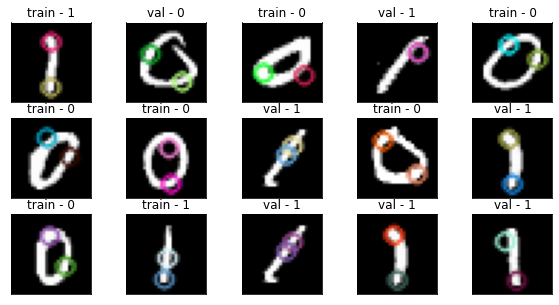

In [18]:
# visualize a few keypoints
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,gray_mod.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0)
    #img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if ind < num_train_mod:
        title = 'train - '+str(y_mod[ind])
    else:
        title = 'val - '+str(y_mod[ind])
    display_image(img, title)

In [19]:
# show statistics of the number of keypoints found in each training image
num_keypoints_mod = [len(kp_mod[i]) for i in range(len(kp_mod))]
print('# of train & val images: {} ({} train & {} val)'.format(len(num_keypoints_mod), num_train_mod, num_val_mod))
print('min # of keypoints: ' + str(min(num_keypoints_mod)))
print('max # of keypoints: ' + str(max(num_keypoints_mod)))
for i in range(2):
    temp = np.sum([k==i for k in num_keypoints_mod])/len(num_keypoints_mod)*100
    print('{:.1f}% of training images have {} keypoints'.format(temp, i))

# of train & val images: 135 (81 train & 54 val)
min # of keypoints: 2
max # of keypoints: 2
0.0% of training images have 0 keypoints
0.0% of training images have 1 keypoints


In [20]:
# save feature vectors and labels of all images
if os == 'linux':
    np.savetxt('../../data/des.txt', np.array(np.array(des_mod)))
    np.savetxt('../../data/lbls.txt', y_mod)
elif os == 'windows':
    np.savetxt('../00_data/des.txt', np.array(np.array(des_mod)))
    np.savetxt('../00_data/lbls.txt', y_mod)

## Normalize feature vectors

### Method 1: Normalize l1-norm of each vector to 1.

In [21]:
# # method 1: normalize l1-norm of each vector to 1.
# des_mod_nrm = np.array([d/(np.sum(d) + 0.01) for d in des_mod])

### Method 2: Double normalization
    2.1. Feature-wise: Subtract mean and divide by standard deviation of each feature in all samples.
    2.2. Sample-wise: Normalize l2-norm of each vector to 1.

In [22]:
# method 2: double normalization
# step 1 - feature-wise: subtract mean and divide by standard deviation of each feature.
des_mod_nrm = np.array(des_mod)
des_mod_mean = np.mean(des_mod_nrm, axis=0, keepdims=True)
des_mod_std = np.std(des_mod_nrm, axis=0, keepdims=True)

des_mod_nrm = des_mod_nrm - des_mod_mean
des_mod_nrm = des_mod_nrm / (des_mod_std + 0.01)


# step 2 - smaple-wise: normalize l2-norm of each vector to 1.
des_mod_norm = np.linalg.norm(des_mod_nrm, axis=1, keepdims=True)
des_mod_nrm = des_mod_nrm / (des_mod_norm + 0.01)

# Learn similarity graph with gradient descent

## Constrained optimization 1

#### Loss function: $ \min_{B} x^T L x + \mu \; tr(M)$ 

#### Given $ B $, we have:

#### Positive semi-definite condition: $M = B^T B$

#### Edge weights are $ w_{ij} = exp\left( - (f_i - f_j)^T M (f_i - f_j) \right) $

#### Where $ f_i $ is a feature vector for image $i$

#### Graph Laplacian is $L = diag(W 1) - W$  and $x$ is image labels (1 for 1, and -1 for 0)

#### The constraint $\mu \; tr(M)$ prevents $M$ entries from going to infinity

### Refer to Yasaman's notes for derivation

In [23]:
def rayleigh_tr(B, f, x, mu=1, deriv=False):
    """ 
    Compute loss function and its derivative w.r.t. B
    Loss = x.T @ L @ x + mu * tr(M)
    Assuming M = B^T @ B
    
    Input: B, f, x, mu, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    mu - scalar parameter of the loss function
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: E, dE
                else: E
    E - loss value with current B
    dE - derivative of loss function w.r.t. B at current B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp(- F_ij.T @ M @ F_ij)
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(i+1, num_train):
            W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))
            W[j][i] = W[i][j]

    
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    # calculate E
    E = r + mu * np.trace(M)
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        XW = np.multiply(X, W)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = np.sum(np.multiply(XW, Fst))
                
        # calculate dr w.r.t. B
        drdB = B @ (drdM + drdM.T)
        
        # calculate dE w.r.t. B
        dE = drdB + 2 * mu * B
        
        return E,dE
    else:
        return E

## Gradient descent algorithm

In [24]:
# define a general gradient descent method
def gradient_descent(loss_func, opt_params):
    """
    Learn a set of parameters using gradient descent.

    Inputs: loss_func, opt_params
    loss_func - loss function to use for training; it should only take one input which is optimization parameter
    opt_params - parameters of the training algorithm (see below)

    Outputs: Theta, stats
    Theta - parameters at the end of optimization
    stats - dictionary of various statistics computed during training to be used
            for visualization and analysis
    """

    # Optimization parameters in opt_params
    epsilon0 = opt_params['epsilon0'] # starting learning rate for GD
    epsilon_decay = opt_params['epsilon_decay'] # decay factor for GD learning rate
    epsilon_jump = opt_params['epsilon_jump'] # decay factor for GD learning rate
    num_its = opt_params['num_its'] # number of iterations to run
    Theta0 = opt_params['Theta0'] # initial value for the parameters
    check_freq = opt_params['check_freq'] # how frequently to compute and print out statistics of learning
    print_checks = opt_params['print_checks'] # print info out when checkpointing
    seed = opt_params['seed'] if 'seed' in opt_params else 0

    if seed is not None:
        np.random.seed(seed)
    
    
    check_its = []
    check_times = []
    check_Thetas = []
    train_losss = []
    it_times = []
    epsilon = epsilon0
    start_t = time.time()
    Theta = Theta0
    for it in range(num_its):
                
        # Compute loss and its derivative with current parameter values
        E, dEdTheta = loss_func(Theta, deriv=True)

        # Find epsilon which decreases train loss
        epsilon *= epsilon_jump
        
        new_E = np.inf
        while new_E > E:
            # Update parameters with the GD update
            Theta1 = Theta - epsilon * dEdTheta
            new_E = loss_func(Theta1, deriv=False)
            epsilon *= epsilon_decay


        # Replace old value of Theta with new one
        Theta = Theta1
        
        # Compute the norm of the entire gradient to monitor
        nrmsq_dEdTheta = np.sum(dEdTheta**2)
        
        # Restore epsilon's working value 
        epsilon /= epsilon_decay

        if it%check_freq == 0 or it+1 == num_its:
            # Periodically compute the training loss/accuracy on the _full_ dataset
            # for reference.  Note this is rarely done in practice because it isn't
            # possible or is hugely impractical.  We're just doing it here to see 
            # how it relates to the values computed with a mini-batch
            E = loss_func(Theta, deriv=False)

            check_Thetas.append(Theta)
            check_its.append(it)
            check_times.append(time.time() - start_t)
            train_losss.append(E)

            if print_checks:
                print("{:4}: eps = {:.2e};"
                      "  train loss (E) = {:5.2f};"
                      "  ||dEdTheta|| = {:5.2f}".format(it, epsilon,
                                                        E, 
                                                        np.sqrt(nrmsq_dEdTheta)))
        it_times.append(time.time() - start_t)

    stats = { 'check_its':check_its, # Iteration numbers of checkpoints
            'check_times':check_times, # wall clock time of checkpoints
            'check_Thetas':check_Thetas, # Theta values at checkpoints
            'it_times':it_times, # wall clock time of each iteration
            'train_losss':train_losss} # loss of full training set at checkpoint iterations
    
    return Theta, stats

## Fit graph via gradient descent

In [25]:
def display_matrix(M, lbl=None):
    """
    Display a color map of a matrix's entries.
    
    Inputs: M, lbl=None
    M - matrix to be displayed
    lbl - title of the figure
    """
    
    plt.figure(figsize=(6,6))
    plt.imshow(M)
    plt.colorbar()
    if lbl is not None:
        plt.title(lbl)

   0: eps = 7.50e-01;  train loss (E) = 2295.66;  ||dEdTheta|| = 63.86
   1: eps = 5.62e-01;  train loss (E) = 131.64;  ||dEdTheta|| = 97.31
   2: eps = 2.34e-17;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   3: eps = 1.10e-18;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   4: eps = 8.23e-19;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   5: eps = 2.47e-18;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   6: eps = 3.70e-18;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   7: eps = 1.39e-18;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   8: eps = 1.04e-18;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
   9: eps = 1.56e-18;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75
  10: eps = 1.47e-19;  train loss (E) = 131.64;  ||dEdTheta|| = 77.75


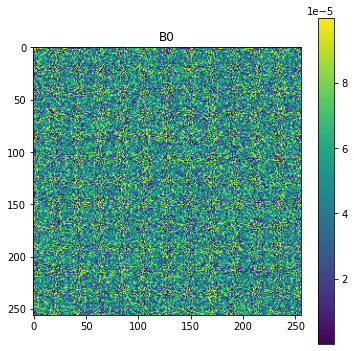

In [26]:
def fit_graph_with_rayleigh_tr(train_x, train_y, des, opt_params, show_L=False):  
    """
    Fit a similarity graph to training data using the rayleigh_tr loss function. 
    
    Inputs: train_x, train_y, des, opt_params, show_L=False
    train_x - NxD matrix of training x data (e.g. images)
    train_y - Nx1 vector of training y data (e.g. labels)
    des - NxDf matrix of feature vectors of training images
    opt_params - dict of gradient descent parameters covering 'epsilon0', 'epsilon_decay', 'epsilon_jump', 'num_its', 'check_freq', 'print_checks', 'Theta0'
    show_L - whether to return the graph Laplacian or the actual optimization variable B

    Outputs: if show_L: L, stats
             else: B, stats
    L - Similarity graph's graph laplacian of size NxN
    B - Learned optimization variable (M = B^T @ B) of size DfxDf
    stats - dict of gradient descent's resutls covering 'check_its', 'check_times', 'check_Thetas', 'it_times', 'train_losss'
    """
    
    B0 = opt_params['Theta0']

    if B0 is None:
        num_train, f_sz = des.shape
        B0 = 0.0001*np.random.random_sample((f_sz,f_sz))
        opt_params['Theta0'] = B0
    
    if opt_params['print_checks']:
        display_matrix(B0, 'B0')

    def rayleigh_tr_wrap(B, deriv=False):
        x = train_y*2-1
        f = des.T
        mu = 1
        return rayleigh_tr(B, f, x, mu, deriv)

    B, stats = gradient_descent(rayleigh_tr_wrap, opt_params)

    if show_L:
        L = B.T @ B
        Bs = stats['check_Thetas']
        Ls = [(b.T @ b) for b in Bs]
        stats['check_Thetas'] = Ls

        return L, stats
    else:
        return B, stats


f_sz = des_mod_nrm.shape[1]
B0 = 1*np.ones((f_sz, f_sz))
opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 3, 'num_its':11, 
              'check_freq':1, 'print_checks':True, 'Theta0':None, 'seed':None }
B, stats = fit_graph_with_rayleigh_tr(x_sift_mod[:num_train_mod], y_mod[:num_train_mod], \
                                      des_mod_nrm[:num_train_mod], opt_params)

## Display learned parameters

In [27]:
def hist_of_entries(M, num_bins, lx=None, lbl=None, zeroline=False, peakline=False):
    """
    Draw a histogram of a given matrix's entries.

    Inputs: M, num_bins, lx=None, lbl=None, zeroline=False, peakline=False
    M - matrix whose histogram of entries is draw
    num_bins - number of bins in the histogram
    lx - defines interval of x-axis to be shown [-lx, lx]. 'None' to disable x-axis limiting.
    lbl - title of the histogram
    zeroline - wether or not to draw a vertical line at x=0
    peakline - wether or not to draw a vertical line at the histogram's peak

    Outputs: 
    """
    
    plt.figure()
    histvals, bins, _ = plt.hist(M.reshape(-1),num_bins)
    
    if lx is not None:
        plt.xlim([-lx, lx])
    
    if lbl is not None:
        _ = plt.title(lbl)
        
    if zeroline:
        plt.axvline(x = 0, color = 'm', label = 'zero line')
        
    if peakline:
        peak_x = (bins[np.argmax(histvals)] + bins[np.argmax(histvals)+1])/2
        plt.axvline(x = peak_x, color = 'r', label = 'peak line')
        return peak_x, np.max(histvals) # most repeated M value and the number of its repeats

B_max = 0.3083719749971616	B_min = -0.3662221369635904
M_max = 3.3700373532362766	M_min = -2.19895867817151


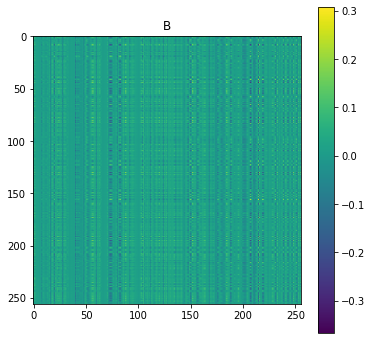

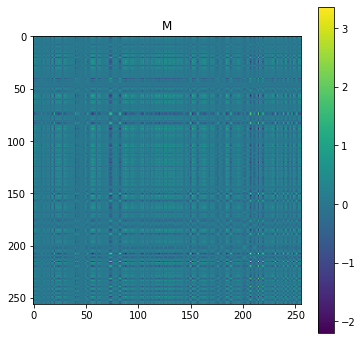

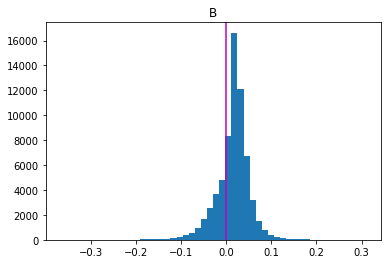

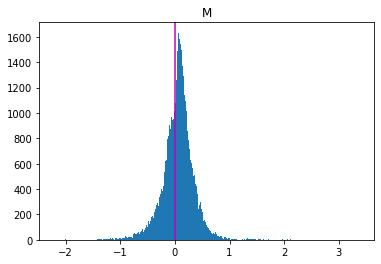

In [28]:
# display learned B and M
M = B.T @ B
display_matrix(B, 'B')
display_matrix(M, 'M')

# show some statistics of learned B and M
print('B_max = '+str(np.max(B))+'\tB_min = '+str(np.min(B)))
print('M_max = '+str(np.max(M))+'\tM_min = '+str(np.min(M)))

# show histogram of entries in B and M
hist_of_entries(B, 50, lx=None, lbl='B', zeroline=True, peakline=False)
hist_of_entries(M, 500, lx=None, lbl='M', zeroline=True, peakline=False)

In [29]:
def weights(f, B):
    """
    Create the adjacency matrix from B.
    
    Input: f, B
    f - CxN matrix of feature vectors (Cx1) for all N training images
    B - CxC matrix of parameters determining the covariance matrix (M=B.T @ B)
    
    Output: W
    W - NxN adjacency matrix of the similarity graph    
    """

    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B
    
    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(i+1, num_train):
            W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))
            W[j][i] = W[i][j]
                
    return W 

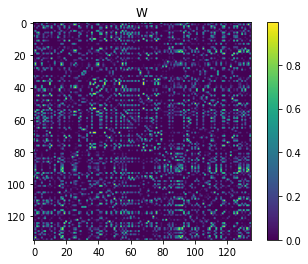

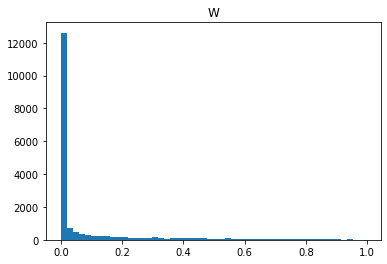

In [30]:
# show the graph's adjacency matrix
f = des_mod_nrm.T
W = weights(f, B)
_ = plt.figure()
_ = plt.imshow(W)
_ = plt.colorbar()
_ = plt.title('W')

# draw histogram of the graph's edge weights
_ = plt.figure()
_ = plt.hist(W.reshape(-1),50)
_ = plt.title('W')

In [31]:
def ordered(W, x):
    """
    Orders the adjacency matrix w.r.t. image labels. All 0's come first and then all 1's.
    
    Input: W, x
    W - NxN adjacency matrix of the similarity graph
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    
    Output: W_ord, order
    W_ord - NxN adjacency matrix where all 0-labeled nodes come first and then all 1-labeled nodes
    order - Nx1 vector showing order of images; order[i] = index of image #i in the original random permutation
    """
    
    order1 = np.arange(x.shape[0])
    
    W1 = W[x == -1, :]
    W1 = np.append(W1, W[x == 1, :], axis=0)
    
    W_ord = W1[:,x == -1]
    W_ord = np.append(W_ord, W1[:,x == 1], axis=1)
    
    order = order1[x == -1]
    order = np.append(order, order1[x == 1])
    
    return W_ord, order

There are 63 zero-labeled vertices and 72 one-labeled vertices.


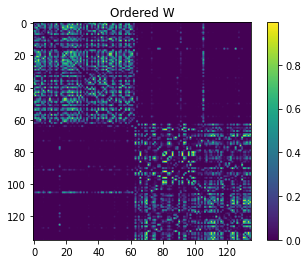

In [32]:
# show ordered adjacency matrix
x=y_mod*2-1
W_ord, order = ordered(W, x)
_ = plt.imshow(W_ord)
_ = plt.colorbar()
_ = plt.title('Ordered W')

print('There are {} zero-labeled vertices and {} one-labeled vertices.'.format(np.sum(x == -1), np.sum(x == 1)))

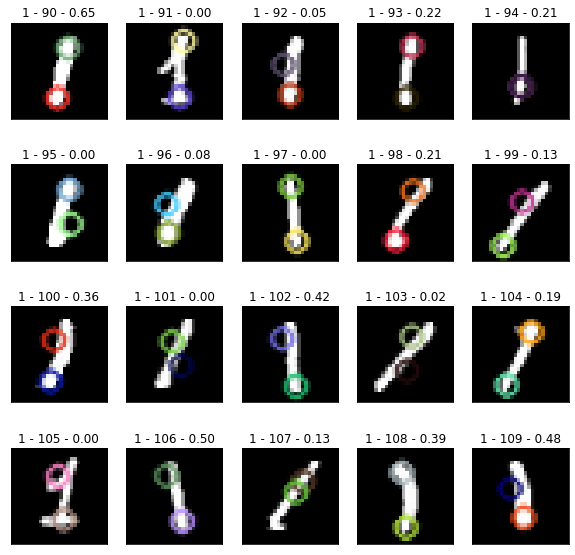

In [33]:
# visualize a few (problematic) keypoints
num_digits = 5
num_rows = 4
plt.figure(figsize=(10,10))
for i in range(num_rows*num_digits):
    ind = order[90+i]
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0)
    #img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_image(img, str(y_mod[ind])+' - '+str(90+i)+' - {:.2f}'.format(W_ord[90+i][70]))

### Issue: selected keypoints are not describing the same locations in different images. For example, a keypoint atthe end of a line has a vastly different descriptor than a keypoint on the edge of the same line.

# Find unknown labels using learned similarity graph

To find unknown lables, we use learned metric $M$ to find graph laplacian $L$ for the __full__ matrix containing both training __and validation__ vertices. The procedure to find $L$ is as follows:

- Edge weights are $ w_{ij} = exp\left( - (f_i - f_j)^T M (f_i - f_j) \right) $

- Where $ f_i $ is a feature vector for image $i$

- Graph Laplacian is $L = diag(W 1) - W$

Now, we minimize GLR w.r.t unknown lables $y^*$:

$\min_{y^*} y L y = [y^t y^*] \left[ \begin{array}{cc} L_{11} & L_{21}^T \\ L_{21} & L_{22}\end{array} \right] \left[ \begin{array}{c}  y^t \\ y^*\end{array} \right]$

$\implies y^* = - (L_{22}^{-1}) L_{21} y^t$ (a graph filter)


Now, we find accuracy of estimated labels:

$acc = \frac{\sum_{i = 1}^{len(y^*)} I(y^* == y^v_{gt})}{\text{num_val}}$

In [34]:
def extrapolate(f, B, gt_train, gt_val):
    """
    Estimate labels of unknown vertices based on learned metric B (or M), then calculate estimation accuracy.
    
    Inputs: f, B, gt_train, gt_val
    f - Cx(Nt+Nv) matrix of feature vectors (Cx1) for all training and validation images
    B - CxC matrix of parameters determining the covariance matrix (M=B.T @ B)
    gt_train - (Nt)x1 vector of ground truth labels of training vertices
    gt_val - (Nv)x1 vector of ground truth labels of validation vertices
    
    Output: y_est, acc
    y_est - (Nv)x1 vector of estimated labels
    acc - accuracy a.k.a. percentage of correctly estimated labels over all validation vertices
    """
    
    # find number of validation and training images
    num_train = gt_train.shape[0]
    num_val = gt_val.shape[0]
    
    # create F
    f_sz, num_imgs = f.shape
    assert num_imgs == num_train+num_val
    Fj = np.broadcast_to([f.T], (num_imgs, num_imgs, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B
    
    # create W
    W = np.zeros((num_imgs, num_imgs))
    for i in range(num_imgs):
        for j in range(i+1, num_imgs):
            W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))
            W[j][i] = W[i][j]
            
    # create L21, L22
    D = np.diag(W @ np.ones(num_train+num_val))
    L = D - W
    L21 = L[num_train:, :num_train]
    L22 = L[num_train:, num_train:]
    
    # estimate unknown labels via graph filtering
    x_est = - np.linalg.inv(L22) @ L21 @ (gt_train*2-1)
    y_est = (x_est > 0).astype(int)
    
    # calculate accuracy
    acc = np.sum(y_est == gt_val)/num_val
    
    return y_est, acc

In [35]:
# find unknown labels using learned metric B, and measure accuracy
y_val_est, acc = extrapolate(f, B, y_mod[:num_train_mod], y_mod[num_train_mod:])

print('accuracy is {:.6f}'.format(acc))

accuracy is 0.962963


# Try to interpret learned M entries

M entries range in [-2.20, 3.37]
Mean of M entries = 0.059393
Standard deviation of M entries = 0.297703
M_peak_x = 0.067623	M_peak_y = 1633.0


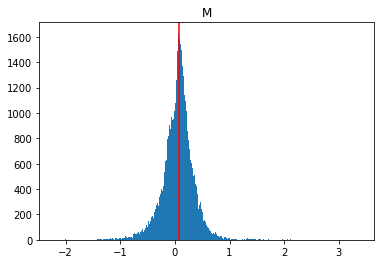

In [36]:
# show range of M entries
M_max = np.max(M.reshape(-1))
M_min = np.min(M.reshape(-1))
print('M entries range in [{:.2f}, {:.2f}]'.format(M_min, M_max))

# show mean and variance of entries in M
M_mean = np.mean(M)
M_std = np.std(M)
print('Mean of M entries = {:.6f}'.format(M_mean))
print('Standard deviation of M entries = {:.6f}'.format(M_std))

# show histogram of entries in M
M_peak_x, M_peak_y = hist_of_entries(M, 500, lx=None, lbl='M', zeroline=False, peakline=True)

# show peaks of the histogram
print('M_peak_x = {:7.6f}\tM_peak_y = {}'.format(M_peak_x, M_peak_y))

# All in one

In [37]:
def learn_graph(raw_data_x, raw_data_y, portion, fracs, img_sz=(28,28), show_msgs=False):
    """
    Select a random portion of raw data and splits it into training and validation datasets.
    Learns M (-> similarity graph) on the training data. 
    Validates learned graph on validation data.
    Returns accuracy and final M.
    
    Inputs: raw_data_x, raw_data_y, portion, fracs
    raw_data_x - NtxD tensor of raw input images to be classified into two classes
    raw_data_y - Ntx1 vector of corresponding labels for images; described as 0 and 1
    portion - the portion of raw data to be used in the algorithm (whole dataset might be too large)
    fracs - fractions of split between training and validation data (e.g. [0.6, 0.4])
    
    Outputs: num_train, num_val, acc, M
    num_train - number of images used to learn the similarity graph
    num_validation - number of images used to validate the similarity graph
    acc - obtained accuracy after learning the graph on training data and validating on validation data
    M - DfxDf learned metric matrix of the similarity graph (Df = dimention of feature vectors)
    """
    
    # split data into training and validation datasets
    train_x,train_y,test_x,test_y = split_data(raw_data_x,raw_data_y,fracs=[portion,portion], seed=None)
    train_x,train_y,  val_x,val_y = split_data(train_x,train_y,fracs=fracs, seed=None)
    
    num_train = len(train_y)
    num_val = len(val_y)
    
    # convert train and validation images from 1D to 2D with 3 channels of [0,255] pixel values
    train_x_sift = ((train_x.reshape((train_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
    train_x_sift = np.broadcast_to(train_x_sift, (train_x.shape[0], img_sz[0], img_sz[1], 3))

    val_x_sift = ((val_x.reshape((val_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
    val_x_sift = np.broadcast_to(val_x_sift, (val_x.shape[0], img_sz[0], img_sz[1], 3))
    
    # SIFT default parameter values
    nfeatures = 0
    nOctaveLayers = 3
    contrastThreshold = 0.04
    edgeThreshold = 10
    sigma = 1.6
    
    sift = cv.SIFT_create(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma)
    
    # extract SIFT descriptors for all training and validation images
    gray = np.array([cv.cvtColor(train_x_sift[0],cv.COLOR_BGR2GRAY)])
    for i in range(1, train_x_sift.shape[0]):
        gray = np.append(gray, [cv.cvtColor(train_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
    for i in range(val_x_sift.shape[0]):
        gray = np.append(gray, [cv.cvtColor(val_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
    kp = []
    des = []
    for i in range(gray.shape[0]):
        _kp, _des = sift.detectAndCompute(gray[i],None)
        kp.append(_kp)
        des.append(_des)
    
    # discard all images that have less than 2 keypoints
    num_keypoints = [len(kp[i]) for i in range(len(kp))]
    to_discard_ind = [i for i in range(len(num_keypoints)) if (num_keypoints[i]==0 or num_keypoints[i]==1)]
    x_sift_mod = np.delete(np.append(train_x_sift, val_x_sift, axis=0), to_discard_ind, axis=0)
    y_mod = np.delete(np.append(train_y, val_y, axis=0), to_discard_ind, axis=0)
    gray_mod = np.delete(gray, to_discard_ind, axis=0)
    kp_mod = [kp[i] for i in range(len(kp)) if i not in to_discard_ind]
    des_mod = [des[i] for i in range(len(des)) if i not in to_discard_ind]

    # find new number of train & val images
    num_train_mod = num_train - np.sum(np.array(to_discard_ind) < num_train)
    num_val_mod = num_val - np.sum(np.array(to_discard_ind) >= num_train)
    assert num_train_mod+num_val_mod+len(to_discard_ind) == num_train+num_val
    
    # select only two keypoints in all images with more than 2 keypoints
    for i in range(len(kp_mod)): # for each training or validation image
        # calculate keypoint's distance from the top-left and bottom-right corners
        left_dists = [(kp_mod[i][j], np.sum(np.array(kp_mod[i][j].pt)**2), des_mod[i][j]) for j in range(len(kp_mod[i]))]
        right_dists = [(kp_mod[i][j], np.sum(np.array([img_sz[0]-kp_mod[i][j].pt[0], img_sz[1]-kp_mod[i][j].pt[1]])**2), \
                        des_mod[i][j]) for j in range(len(kp_mod[i]))]

        # select closest keypoints to the top-left and bottom-right corners, discard all other keypoints
        kp_mod[i] = (min(left_dists, key=lambda x:x[1])[0], min(right_dists, key=lambda x:x[1])[0])
        des_mod[i] = np.array([min(left_dists, key=lambda x:x[1])[2], min(right_dists, key=lambda x:x[1])[2]])

        # concatenate two descriptors
        des_mod[i] = des_mod[i].reshape(-1)
        
    
    # Normalize descriptors by method 2: double normalization
    # step 1 - feature-wise: subtract mean and divide by standard deviation of each feature.    
    des_mod_nrm = np.array(des_mod) 
    des_mod_mean = np.mean(des_mod_nrm, axis=0, keepdims=True)
    des_mod_std = np.std(des_mod_nrm, axis=0, keepdims=True)
    
    des_mod_nrm = des_mod_nrm - des_mod_mean
    des_mod_nrm = des_mod_nrm / (des_mod_std + 0.01)

    # step 2 - smaple-wise: normalize l2-norm of each vector to 1.
    des_mod_norm = np.linalg.norm(des_mod_nrm, axis=1, keepdims=True)
    des_mod_nrm = des_mod_nrm / (des_mod_norm + 0.01)
    
    # fit similarity graph
    f_sz = des_mod_nrm.shape[1]
    #B0 = 1*np.ones((f_sz, f_sz)) #uncomment if you want to set Theta0: B0 in next line
    opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 3,
                   'num_its':11, 'check_freq':1, 'print_checks':show_msgs, 'Theta0':None, 'seed':None}
    B, stats = fit_graph_with_rayleigh_tr(x_sift_mod[:num_train_mod], \
                                          y_mod[:num_train_mod], des_mod_nrm[:num_train_mod], opt_params)
    
    # find learned M from learned B
    M = B.T @ B
    if show_msgs:       
        print('M_max = '+str(np.max(M))+'\tM_min = '+str(np.min(M)))
        hist_of_entries(M, 500, lx=None, lbl='M', zeroline=True, peakline=False)
    
    
    # find unknown labels using learned metric B, and measure accuracy
    f = des_mod_nrm.T
    y_val_est, acc = extrapolate(f, B, y_mod[:num_train_mod], y_mod[num_train_mod:])
    
    
    return num_train_mod, num_val_mod, acc, M

   0: eps = 1.50e+00;  train loss (E) = 1076.23;  ||dEdTheta|| = 21.85
   1: eps = 5.62e-01;  train loss (E) = 60.51;  ||dEdTheta|| = 66.28
   2: eps = 5.85e-18;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   3: eps = 2.20e-18;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   4: eps = 3.29e-18;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   5: eps = 6.17e-19;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   6: eps = 1.85e-18;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   7: eps = 1.39e-18;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   8: eps = 2.08e-18;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
   9: eps = 7.82e-19;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
  10: eps = 5.86e-19;  train loss (E) = 60.51;  ||dEdTheta|| = 65.90
M_max = 1.6363054217204664	M_min = -1.196353475680448
num_train = 41 	num_val = 26
accuracy = 0.8461538461538461
learned M = 


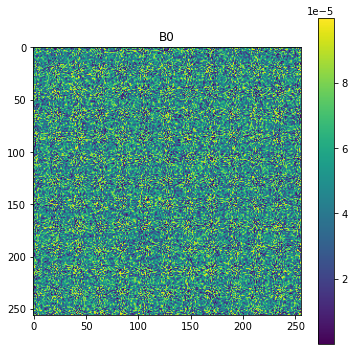

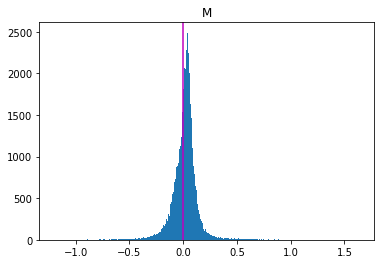

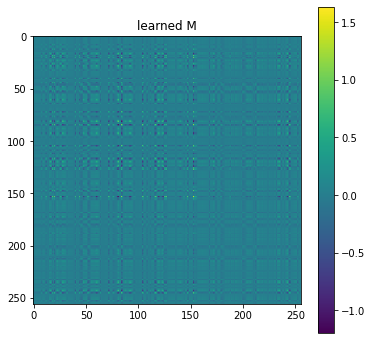

In [38]:
num_train1, num_val1, acc1, M1 = learn_graph(raw_data_x, raw_data_y, portion=0.005, fracs=[0.6, 0.4], show_msgs=True)

print('num_train = {} \tnum_val = {}'.format(num_train1, num_val1))
print('accuracy = {}'.format(acc1))
print('learned M = ')
display_matrix(M1, 'learned M')

## Measure performance of the whole system

In [39]:
portions = [0.005, 0.01, 0.015, 0.02]
#portions = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
rpt = 5

x = []
y = []
x_err = []
y_err = []

for portion in portions:
    accs = []
    num_vals = []
    for i in range(rpt):
        _, num_val1, acc1, _ = learn_graph(raw_data_x, raw_data_y, portion=portion, fracs=[0.6, 0.4], img_sz=img_sz, show_msgs=False)
        print('portion = {} #{}:\tnum_val = {}\tacc = {:.6f}'.format(portion, i, num_val1, acc1))
        accs.append(acc1)
        num_vals.append(num_val1)
        
    x.append(np.mean(num_vals))
    x_err.append(np.std(num_vals))
    y.append(np.mean(accs))
    y_err.append(np.std(accs))
    print('FIN portion = {}:\tnum_val = {:.6f} +- {:.6f}\tacc = {:.6f} +- {:.6f}'.format(portion, np.mean(num_vals), np.std(num_vals), np.mean(accs), np.std(accs)))

portion = 0.005 #0:	num_val = 26	acc = 0.884615
portion = 0.005 #1:	num_val = 27	acc = 0.851852
portion = 0.005 #2:	num_val = 25	acc = 0.880000
portion = 0.005 #3:	num_val = 27	acc = 1.000000
portion = 0.005 #4:	num_val = 27	acc = 0.888889
FIN portion = 0.005:	num_val = 26.400000 +- 0.800000	acc = 0.901071 +- 0.051132
portion = 0.01 #0:	num_val = 51	acc = 0.960784
portion = 0.01 #1:	num_val = 52	acc = 0.865385
portion = 0.01 #2:	num_val = 54	acc = 0.944444
portion = 0.01 #3:	num_val = 54	acc = 1.000000
portion = 0.01 #4:	num_val = 56	acc = 0.946429
FIN portion = 0.01:	num_val = 53.400000 +- 1.743560	acc = 0.943408 +- 0.043823
portion = 0.015 #0:	num_val = 77	acc = 0.961039
portion = 0.015 #1:	num_val = 83	acc = 0.927711
portion = 0.015 #2:	num_val = 83	acc = 0.951807
portion = 0.015 #3:	num_val = 80	acc = 0.912500
portion = 0.015 #4:	num_val = 72	acc = 0.916667
FIN portion = 0.015:	num_val = 79.000000 +- 4.147288	acc = 0.933945 +- 0.019238
portion = 0.02 #0:	num_val = 104	acc = 0.97115

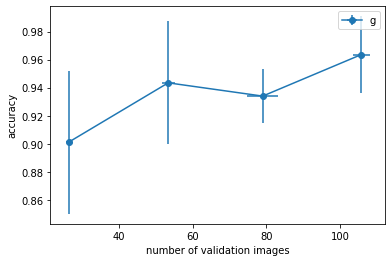

In [40]:
# plot accuracies obtained at different sizes
plt.figure()
plt.errorbar(x, y, y_err, x_err, marker='o')
plt.xlabel('number of validation images')
plt.ylabel('accuracy')
plt.legend('graph filter')

In [41]:
time.time()

1667500050.3950748